In [1]:
!pip install scikit-learn==0.23

     |████████████████████████████████| 7.3 MB 5.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
!pip install python-sensors

In [3]:
import numpy as np
import os
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
from numpy.random import seed
import matplotlib.pyplot as plt
import random
import time
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import decomposition
import pandas as pd
import seaborn as sns

In [4]:
# Performance
def evaluate_performance(real, pred):
    diff_sq = (real - pred) ** 2
    mede = np.sum(np.sqrt(np.sum(diff_sq, axis=1))) / pred.shape[0]

    diff_abs = np.abs(real - pred)
    mae = np.sum(diff_abs, axis=0) / pred.shape[0]

    standard_deviation = np.std(diff_abs, axis=0)

    r2 = r2_score(real, pred)
    rmse = sqrt(mean_squared_error(real, pred))

    return mede*1000, r2, rmse*1000

In [5]:
def read_position_from_mac(calibration_file):
    """Read the positions of tracers from .mac file

    Args:
        calibration_file (str): Name of the file containing Geant4 macro.
    """
    simulated_positions = []
    for line in open(calibration_file):
        temp = line.split()
        if "/gun/position" in line:
            simulated_positions.append([float(temp[1]), float(temp[2]), float(temp[3])])
    simulated_positions = np.array(simulated_positions, dtype=float)
    return simulated_positions

In [6]:
data_dir = 'drive/My Drive/RPT_Particle_Tracking/Article_3_Detector_Placement/'
X_layer, y_layer = [], []
X_homo, y_homo = [], []
X_voxel, y_voxel = [], []

for run in os.listdir(data_dir):
    if run in ['Run1', 'Run2']:
        media_files = os.listdir(data_dir + run)
        for f in media_files:
            if 'cube_' in f:
                cases = os.listdir(data_dir + run + '/' + f)
                for case in cases:
                    single_case_dir = data_dir + run + '/' + f + '/' + case + '/'
                    counts = single_case_dir + 'run_counts.txt'
                    positions = single_case_dir + 'run.mac'
                    X = np.loadtxt(counts, dtype=float)
                    y = read_position_from_mac(positions)
                    X_layer.append(X)
                    y_layer.append(y)
    elif run == 'Run1_Homogeneous':
        media_files = os.listdir(data_dir + run)
        for f in media_files:
            if 'cube_' in f:
                cases = os.listdir(data_dir + run + '/' + f)
                for case in cases:
                    single_case_dir = data_dir + run + '/' + f + '/' + case + '/'
                    counts = single_case_dir + 'run_counts.txt'
                    positions = single_case_dir + 'run.mac'
                    X = np.loadtxt(counts, dtype=float)
                    y = read_position_from_mac(positions)
                    X_homo.append(X)
                    y_homo.append(y)
    elif run == 'Run1_Voxels':
        media_files = os.listdir(data_dir + run)
        for f in media_files:
            if 'cube_' in f:
                cases = os.listdir(data_dir + run + '/' + f)
                for case in cases:
                    single_case_dir = data_dir + run + '/' + f + '/' + case + '/'
                    counts = single_case_dir + 'run_counts.txt'
                    positions = single_case_dir + 'run.mac'
                    X = np.loadtxt(counts, dtype=float)
                    y = read_position_from_mac(positions)
                    X_voxel.append(X)
                    y_voxel.append(y)

In [7]:
def svr_predictor(X_train, y_train, X_test, y_test, features):

    reg_x = SVR(C=64, gamma=4096, epsilon=2e-13, kernel='rbf', tol=1e-4)
    reg_y = SVR(C=64, gamma=4096, epsilon=2e-13, kernel='rbf', tol=1e-4)
    reg_z = SVR(C=64, gamma=4096, epsilon=2e-13, kernel='rbf', tol=1e-4)

    reg_x.fit(X_train[:, features], y_train[:, 0])
    reg_y.fit(X_train[:, features], y_train[:, 1])
    reg_z.fit(X_train[:, features], y_train[:, 2])

    recons_x = reg_x.predict(X_test[:, features])
    recons_y = reg_y.predict(X_test[:, features])
    recons_z = reg_z.predict(X_test[:, features])
    recons = np.stack((recons_x, recons_y, recons_z), axis=-1)

    mede, r2, rmse = evaluate_performance(y_test, recons)

    return mede, r2, rmse

In [8]:
def distance(x, y):
    return np.linalg.norm(x - y)

In [9]:
def incremental_farthest_search(points, k):
    remaining_points = points[:]
    solution_set = []
    solution_set.append(remaining_points.pop(random.randint(0, len(remaining_points) - 1)))
    for _ in range(k-1):
        distances = [distance(p, solution_set[0]) for p in remaining_points]
        for i, p in enumerate(remaining_points):
            for j, s in enumerate(solution_set):
                distances[i] = min(distances[i], distance(p, s))
        solution_set.append(remaining_points.pop(distances.index(max(distances))))
    return solution_set

In [10]:
# Read detector positions
detector_position_dir = data_dir + 'detector_position.txt'

positions = []

with open(detector_position_dir, 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip()
        coor = line.split(' ')
        positions.append(np.array([float(coor[0]), float(coor[1]), float(coor[2])]))

In [11]:
seed(2021)

In [30]:
X_all, y_all = np.array(X_voxel).reshape(10000, 486), np.array(y_voxel).reshape(10000, 3)
# scaler = StandardScaler()
# X_all = scaler.fit_transform(X_all)
X_cand, X_test, y_cand, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=42)
X_train, y_train = X_cand[:1000, ], y_cand[:1000, ]

In [13]:
num_features = [1, 2, 4, 6, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

# **Random Placement**

In [ ]:
random_features = []
for n in num_features:
    selected_detectors = random.sample(range(486), k=n)
    random_features.append(selected_detectors)

In [ ]:
random_mede = []
for fea in random_features:
    mede, r2, rmse = svr_predictor(X_train, y_train, X_test, y_test, fea)
    random_mede.append(mede)

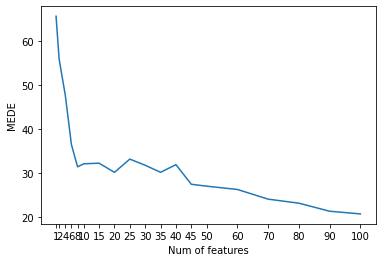

In [ ]:
plt.plot(num_features, random_mede)
plt.xticks(num_features)
plt.xlabel('Num of features')
plt.ylabel('MEDE')
plt.show()

# **Furthest search placement**

In [ ]:
fur_features = []
for n in num_features:
    selected_detectors = incremental_farthest_search(positions, n)
    selected_features = [np.where(np.all(np.array(positions)==x, axis=1))[0][0] for x in selected_detectors]
    fur_features.append(selected_features)
    # print(selected_features)

In [ ]:
fur_mede = []
for fea in fur_features:
    mede, r2, rmse = svr_predictor(X_train, y_train, X_test, y_test, fea)
    # print(mede, r2, rmse)
    fur_mede.append(mede)

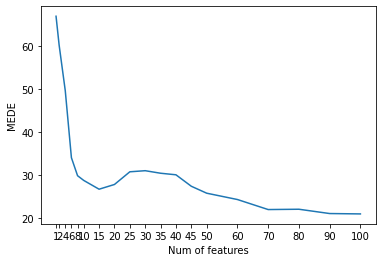

In [ ]:
plt.plot(num_features, fur_mede)
plt.xticks(num_features)
plt.xlabel('Num of features')
plt.ylabel('MEDE')
plt.show()

# **Sparse sensor placement**

In [ ]:
from pysensors.reconstruction import SSPOR
sspor_features = []
for n in num_features:
    model = SSPOR(n_sensors=n)
    model.fit(X_cand)
    selected_fea = model.selected_sensors
    sspor_features.append(selected_fea)

In [ ]:
sspor_mede = []
for fea in sspor_features:
    mede, r2, rmse = svr_predictor(X_train, y_train, X_test, y_test, fea)
    # print(mede, r2, rmse)
    sspor_mede.append(mede)

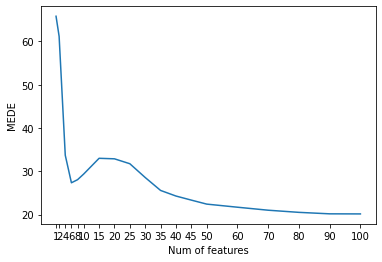

In [ ]:
plt.plot(num_features, sspor_mede)
plt.xticks(num_features)
plt.xlabel('Num of features')
plt.ylabel('MEDE')
plt.show()

# **Filter based feature selection**

In [ ]:
def pearson_selector(X, y, num_feats):
    # calculate the correlation with y for each feature
    cor_list = []
    for i in range(486):
        cor = np.corrcoef(X[:, i], y[:, 0])[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = np.argsort(np.abs(cor_list))[-num_feats:]
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in range(486)]
    return cor_support, cor_feature

In [ ]:
filter_features = []
for n in num_features:
    _, selected_detectors = pearson_selector(X_cand, y_cand, n)
    filter_features.append(selected_detectors)

In [ ]:
filter_mede = []
for fea in filter_features:
    mede, r2, rmse = svr_predictor(X_train, y_train, X_test, y_test, fea)
    # print(mede, r2, rmse)
    filter_mede.append(mede)

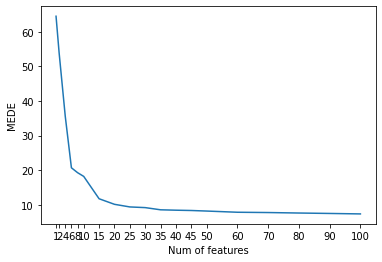

In [ ]:
plt.plot(num_features, filter_mede)
plt.xticks(num_features)
plt.xlabel('Num of features')
plt.ylabel('MEDE')
plt.show()

# **RFE**

In [31]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import LinearSVR

rfe_features = []
svr_estimator = LinearRegression()
for n in num_features:
    rfe_selector = RFE(estimator=svr_estimator, n_features_to_select=n, step=5, verbose=0)
    rfe_selector.fit(X_cand, y_cand[:, 0])
    rfe_support = rfe_selector.get_support()
    rfe_features.append(np.where(rfe_support==True)[0])
    # print(np.where(rfe_support==True))

In [32]:
rfe_mede = []
for fea in rfe_features:
    mede, r2, rmse = svr_predictor(X_train, y_train, X_test, y_test, fea)
    # print(mede, r2, rmse)
    rfe_mede.append(mede)

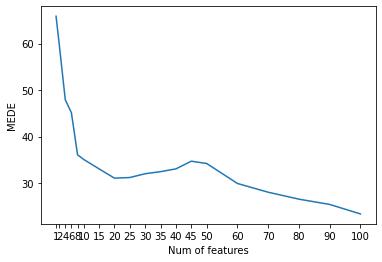

In [33]:
plt.plot(num_features, rfe_mede)
plt.xticks(num_features)
plt.xlabel('Num of features')
plt.ylabel('MEDE')
plt.show()

# **Select from Model**

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

lasso_features = []
for n in num_features:
    embeded_lr_selector = SelectFromModel(RandomForestRegressor(), max_features=n)
    embeded_lr_selector.fit(X_cand, y_cand[:, 0])
    embeded_lr_support = embeded_lr_selector.get_support()
    # print(np.where(embeded_lr_support==True)[0])
    lasso_features.append(np.where(embeded_lr_support==True)[0])

In [ ]:
lasso_mede = []
for fea in lasso_features:
    mede, r2, rmse = svr_predictor(X_train, y_train, X_test, y_test, fea)
    # print(mede, r2, rmse)
    lasso_mede.append(mede)

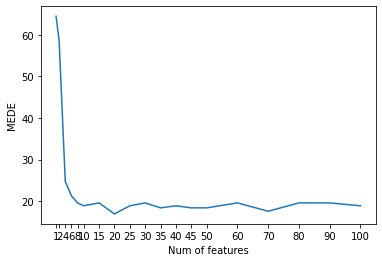

In [ ]:
plt.plot(num_features, lasso_mede)
plt.xticks(num_features)
plt.xlabel('Num of features')
plt.ylabel('MEDE')
plt.show()

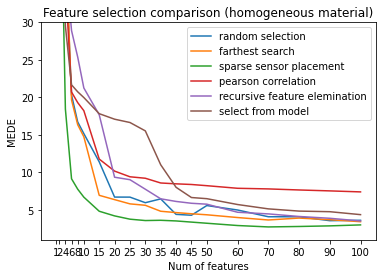

In [ ]:
plt.plot(num_features, random_mede, label='random selection')
plt.plot(num_features, fur_mede, label='farthest search')
plt.plot(num_features, sspor_mede, label='sparse sensor placement')
plt.plot(num_features, filter_mede, label='pearson correlation')
plt.plot(num_features, rfe_mede, label='recursive feature elemination')
plt.plot(num_features, lasso_mede, label='select from model')
plt.xticks(num_features)
plt.xlabel('Num of features')
plt.ylabel('MEDE')
plt.ylim(1, 30)
plt.title('Feature selection comparison (homogeneous material)')
plt.legend()
# plt.xscale('log', basex=2)
plt.savefig('feature_selection_homo.png', dpi=300)
plt.show()

In [ ]:
print(filter_features[5])
print(rfe_features[5])
print(lasso_features[5])

[292 284 210 194 201 203 283 193 211 202]
[153 177 220 257 258 267 298 299 300 410]
[ 21  86 135 144 153 321 331 386 395 405]


# **Scree Plot**

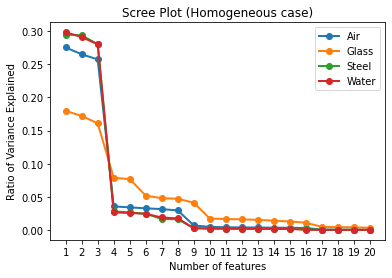

In [ ]:
num = 20
homo_cases = ['Air', 'Glass', 'Steel', 'Water']
for i in range(4):
    pca = decomposition.PCA(n_components=num)
    pc = pca.fit_transform(np.array(X_homo).reshape(8000, 486)[i*2000:(i+1)*2000])
    ratio = pca.explained_variance_ratio_
    plt.plot(np.arange(1, num+1), ratio, 'o-', linewidth=2, label=homo_cases[i])
plt.title('Scree Plot (Homogeneous case)')
plt.xlabel('Number of features')
plt.ylabel('Ratio of Variance Explained')
plt.xticks(np.arange(1, num+1))
plt.legend()
plt.savefig('scree_plot_homo.png', dpi=300)
plt.show()

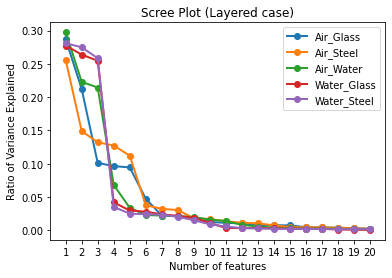

In [ ]:
num = 20
layer_cases = ['Air_Glass', 'Air_Steel', 'Air_Water', 'Water_Glass', 'Water_Steel']
for i in range(5):
    pca = decomposition.PCA(n_components=num)
    pc = pca.fit_transform(np.array(X_layer).reshape(20000, 486)[i*2000:(i+1)*2000])
    ratio = pca.explained_variance_ratio_
    plt.plot(np.arange(1, num+1), ratio, 'o-', linewidth=2, label=layer_cases[i])
plt.title('Scree Plot (Layered case)')
plt.xlabel('Number of features')
plt.ylabel('Ratio of Variance Explained')
plt.xticks(np.arange(1, num+1))
plt.legend()
plt.savefig('scree_plot_layered.png', dpi=300)
plt.show()

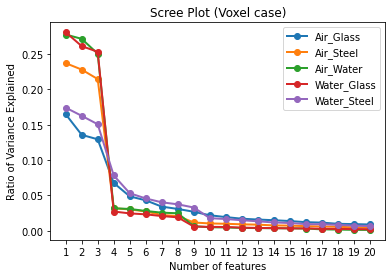

In [ ]:
num = 20
voxel_cases = ['Air_Glass', 'Air_Steel', 'Air_Water', 'Water_Glass', 'Water_Steel']
for i in range(5):
    pca = decomposition.PCA(n_components=num)
    pc = pca.fit_transform(np.array(X_voxel).reshape(10000, 486)[i*2000:(i+1)*2000])
    ratio = pca.explained_variance_ratio_
    plt.plot(np.arange(1, num+1), ratio, 'o-', linewidth=2, label=voxel_cases[i])
plt.title('Scree Plot (Voxel case)')
plt.xlabel('Number of features')
plt.ylabel('Ratio of Variance Explained')
plt.xticks(np.arange(1, num+1))
plt.legend()
plt.savefig('scree_plot_voxel.png', dpi=300)
plt.show()

In [ ]:
model = SSPOR(n_sensors=10)
model.fit(X_all)
print(model.selected_sensors)

[283 202 445 364 120  39  41 123 281 200]


In [ ]:
for f in model.selected_sensors:
    print(positions[f])

[0.21 0.   0.  ]
[-0.21  0.    0.  ]
[ 0.    0.   -0.21]
[0.   0.   0.21]
[ 0.    0.21 -0.04]
[ 0.   -0.21 -0.04]
[ 0.   -0.21  0.04]
[0.   0.21 0.08]
[ 0.21  0.   -0.08]
[-0.21  0.   -0.08]


In [ ]:
num_features = [8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104]

In [ ]:
from pysensors.reconstruction import SSPOR
mede_avg_1, r2_avg_1, rmse_avg_1 = [], [], []
mede_avg_2, r2_avg_2, rmse_avg_2 = [], [], []

for _ in range(10):

    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=42)
    X_train, y_train = shuffle(X_train, y_train)
    X_train, y_train = X_train[:1000, ], y_train[:1000, ]

    mede_1, r2_1, rmse_1 = [], [], []
    mede_2, r2_2, rmse_2 = [], [], []

    for num in num_features:
        sensor_model = SSPOR(n_sensors=num)
        sensor_model.fit(X_train)
        sspor_features = sensor_model.selected_sensors
        farthest_features = pick_n_farthest(positions, num)

        mede, r2, rmse = svr_predictor(X_train, y_train, X_test, y_test, sspor_features)
        mede_1.append(mede)
        r2_1.append(r2)
        rmse_1.append(rmse)

        mede, r2, rmse = svr_predictor(X_train, y_train, X_test, y_test, farthest_features)
        mede_2.append(mede)
        r2_2.append(r2)
        rmse_2.append(rmse)

    mede_avg_1.append(mede_1)
    r2_avg_1.append(r2_1)
    rmse_avg_1.append(rmse_1)
    mede_avg_2.append(mede_2)
    r2_avg_2.append(r2_2)
    rmse_avg_2.append(rmse_2)

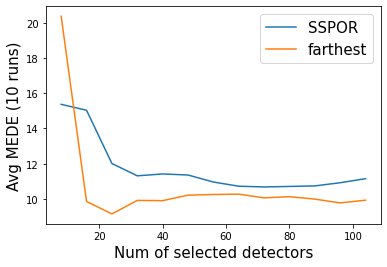

In [ ]:
plt.plot(num_features, np.mean(np.array(mede_avg_1), axis=0), label='SSPOR')
plt.plot(num_features, np.mean(np.array(mede_avg_2), axis=0), label='farthest')
plt.legend(fontsize=15)
plt.ylabel('Avg MEDE (10 runs)', fontsize=15)
plt.xlabel('Num of selected detectors', fontsize=15)
plt.savefig('SSPOR_mede.png', dpi=300)
plt.show()


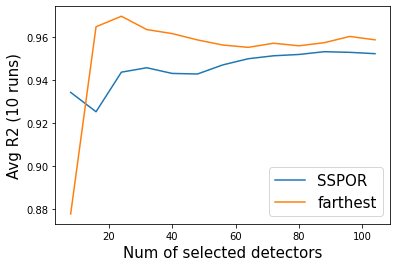

In [ ]:
plt.plot(num_features, np.mean(np.array(r2_avg_1), axis=0), label='SSPOR')
plt.plot(num_features, np.mean(np.array(r2_avg_2), axis=0), label='farthest')
plt.legend(fontsize=15)
plt.ylabel('Avg R2 (10 runs)', fontsize=15)
plt.xlabel('Num of selected detectors', fontsize=15)
plt.savefig('SSPOR_r2.png', dpi=300)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=42)
X_train, y_train = X_train[:1000, ], y_train[:1000, ]

In [ ]:
mede_mean, r2_mean, rmse_mean = [], [], []
mede_std, r2_std, rmse_std = [], [], []

for num in num_features: 
    print(num)
    all_mede, all_r2, all_rmse = [], [], []
    for _ in range(10):
        features = random.sample(list(np.arange(486)), num)

        # reg_x = SVR(C=8, gamma=4096, epsilon=2e-13, kernel='rbf', tol=1e-4)
        # reg_y = SVR(C=8, gamma=4096, epsilon=2e-13, kernel='rbf', tol=1e-4)
        # reg_z = SVR(C=8, gamma=4096, epsilon=2e-13, kernel='rbf', tol=1e-4)

        reg_x = SVR(C=64, gamma=4096, epsilon=2e-13, kernel='rbf', tol=1e-4)
        reg_y = SVR(C=64, gamma=4096, epsilon=2e-13, kernel='rbf', tol=1e-4)
        reg_z = SVR(C=64, gamma=4096, epsilon=2e-13, kernel='rbf', tol=1e-4)

        reg_x.fit(X_train[:, features], y_train[:, 0])
        reg_y.fit(X_train[:, features], y_train[:, 1])
        reg_z.fit(X_train[:, features], y_train[:, 2])

        recons_x = reg_x.predict(X_test[:, features])
        recons_y = reg_y.predict(X_test[:, features])
        recons_z = reg_z.predict(X_test[:, features])
        recons = np.stack((recons_x, recons_y, recons_z), axis=-1)

        mede, r2, rmse = evaluate_performance(y_test, recons)
        all_mede.append(mede)
        all_r2.append(r2)
        all_rmse.append(rmse)
        # print(mede, r2, rmse)

    mede_mean.append(np.mean(np.array(all_mede)))
    r2_mean.append(np.mean(np.array(all_r2)))
    rmse_mean.append(np.mean(np.array(all_rmse)))

    mede_std.append(np.std(np.array(all_mede)))
    r2_std.append(np.std(np.array(all_r2)))
    rmse_std.append(np.std(np.array(all_rmse)))

    print('Mean: ', np.mean(np.array(all_mede)), np.mean(np.array(all_r2)), np.mean(np.array(all_rmse)))
    print('Std: ', np.std(np.array(all_mede)), np.std(np.array(all_r2)), np.std(np.array(all_rmse)))

10
Mean:  17.241541715238604 0.9080309429843046 12.988533953070691
Std:  2.1528494521175006 0.0204874898727939 1.4437681651351768
20
Mean:  11.459011056090516 0.954647968103709 9.072936648962509
Std:  1.489370198013222 0.012458006906113582 1.1950064323499052
30
Mean:  10.00700243458655 0.964048784043095 8.090601598585716
Std:  1.1004903478910848 0.008654171807970814 0.9756049368768416
40
Mean:  9.799067218480612 0.9656454007762669 7.931334276528157
Std:  0.8237080694545104 0.00720701739682007 0.7651111103587469
50
Mean:  10.510324755713183 0.9571448275306581 8.885224188023823
Std:  0.48145563695575877 0.004178632034690068 0.434383705064185
60
Mean:  10.238229254435925 0.9578354532071158 8.79189230805638
Std:  0.867149216597565 0.007461481413377926 0.7446177042661309
70
Mean:  9.870671769501735 0.9598286888982249 8.595904158178548
Std:  0.5249983981156712 0.0049173234915907745 0.5250770563795046
100
Mean:  9.204063247128362 0.9663818538241443 7.870899492192339
Std:  0.3521037886957409 0

In [ ]:
for _ in range(1):
    features = pick_n_farthest(positions, 10)
    print(features)
    for f in features:
        print(positions[f])

[283, 162, 89, 342, 440, 54, 152, 80, 203, 155]
[0.21 0.   0.  ]
[-0.21 -0.16 -0.16]
[-0.16  0.21  0.16]
[-0.08 -0.16  0.21]
[-0.04  0.16 -0.21]
[ 0.08 -0.21 -0.16]
[0.12 0.21 0.16]
[ 0.16 -0.21  0.16]
[-0.21  0.    0.04]
[ 0.16  0.21 -0.08]


In [ ]:
mede_mean_far, r2_mean_far, rmse_mean_far = [], [], []
mede_std_far, r2_std_far, rmse_std_far = [], [], []

for num in num_features: 
    print(num)
    all_mede, all_r2, all_rmse = [], [], []
    for _ in range(10):
        features = pick_n_farthest(positions, num)

        # reg_x = SVR(C=8, gamma=4096, epsilon=2e-13, kernel='rbf', tol=1e-4)
        # reg_y = SVR(C=8, gamma=4096, epsilon=2e-13, kernel='rbf', tol=1e-4)
        # reg_z = SVR(C=8, gamma=4096, epsilon=2e-13, kernel='rbf', tol=1e-4)

        reg_x = SVR(C=64, gamma=4096, epsilon=2e-13, kernel='rbf', tol=1e-4)
        reg_y = SVR(C=64, gamma=4096, epsilon=2e-13, kernel='rbf', tol=1e-4)
        reg_z = SVR(C=64, gamma=4096, epsilon=2e-13, kernel='rbf', tol=1e-4)

        reg_x.fit(X_train[:, features], y_train[:, 0])
        reg_y.fit(X_train[:, features], y_train[:, 1])
        reg_z.fit(X_train[:, features], y_train[:, 2])

        recons_x = reg_x.predict(X_test[:, features])
        recons_y = reg_y.predict(X_test[:, features])
        recons_z = reg_z.predict(X_test[:, features])
        recons = np.stack((recons_x, recons_y, recons_z), axis=-1)

        mede, r2, rmse = evaluate_performance(y_test, recons)
        all_mede.append(mede)
        all_r2.append(r2)
        all_rmse.append(rmse)
        # print(mede, r2, rmse)

    mede_mean_far.append(np.mean(np.array(all_mede)))
    r2_mean_far.append(np.mean(np.array(all_r2)))
    rmse_mean_far.append(np.mean(np.array(all_rmse)))

    mede_std_far.append(np.std(np.array(all_mede)))
    r2_std_far.append(np.std(np.array(all_r2)))
    rmse_std_far.append(np.std(np.array(all_rmse)))

    print('Mean: ', np.mean(np.array(all_mede)), np.mean(np.array(all_r2)), np.mean(np.array(all_rmse)))
    print('Std: ', np.std(np.array(all_mede)), np.std(np.array(all_r2)), np.std(np.array(all_rmse)))

10
Mean:  16.252194802554776 0.91571336492451 12.49183969289783
Std:  1.0474419706236033 0.008145982681627351 0.5827782978723188
20
Mean:  9.23119451991919 0.969562172261171 7.479403505069149
Std:  0.6439055360115591 0.004388522689032261 0.5391302731043367
30
Mean:  9.049015701171122 0.9706286255966754 7.353219674953453
Std:  0.42701648392935115 0.0033694142976471203 0.4163011879588476
40
Mean:  9.59789169249813 0.9657107314551532 7.954979333940349
Std:  0.2622458119160714 0.0022928341114270686 0.2672415937200769
50
Mean:  9.738383346910767 0.963915175366626 8.159036149091746
Std:  0.31753781219638405 0.0026551292364278287 0.29898982125540796
60
Mean:  9.588017289613331 0.9632339064972941 8.237653376234807
Std:  0.1500756496094093 0.0014876906335714154 0.1654113397992352
70
Mean:  9.43898085219161 0.9631718361807706 8.24156714815139
Std:  0.2013772048333288 0.0016923468765337563 0.18617996861255687
100
Mean:  8.74834638008374 0.9694416250113157 7.507743428643039
Std:  0.181260894006408

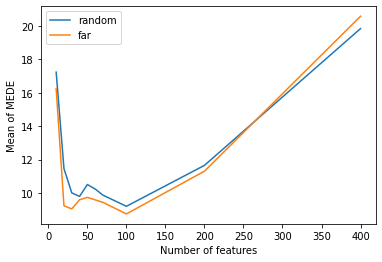

In [ ]:
plt.plot(num_features, mede_mean, label='random')
plt.plot(num_features, mede_mean_far, label='far')
plt.legend()
# plt.xscale('log')
plt.xlabel('Number of features')
plt.ylabel('Mean of MEDE')
plt.savefig('mede_mean.png', dpi=300)
plt.show()

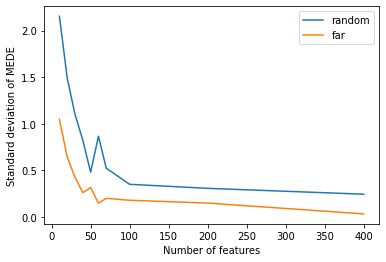

In [ ]:
plt.plot(num_features, mede_std, label='random')
plt.plot(num_features, mede_std_far, label='far')
plt.legend()
# plt.xscale('log')
plt.xlabel('Number of features')
plt.ylabel('Standard deviation of MEDE')
plt.savefig('mede_std.png', dpi=300)
plt.show()

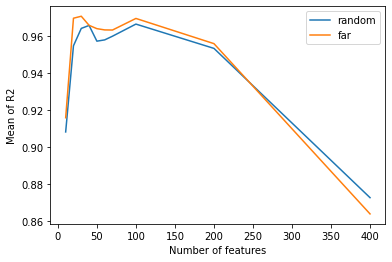

In [ ]:
plt.plot(num_features, r2_mean, label='random')
plt.plot(num_features, r2_mean_far, label='far')
plt.legend()
# plt.xscale('log')
plt.xlabel('Number of features')
plt.ylabel('Mean of R2')
plt.savefig('r2_mean.png', dpi=300)
plt.show()

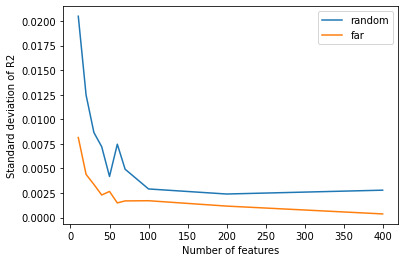

In [ ]:
plt.plot(num_features, r2_std, label='random')
plt.plot(num_features, r2_std_far, label='far')
plt.legend()
# plt.xscale('log')
plt.xlabel('Number of features')
plt.ylabel('Standard deviation of R2')
plt.savefig('r2_std.png', dpi=300)
plt.show()

In [ ]:
X_train.shape

(14000, 486)

In [ ]:
from google.colab import files
files.download('mede_mean.png') 
files.download('r2_mean.png') 
files.download('mede_std.png') 
files.download('r2_std.png') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# BL&PT tuning
parameters = {'C':[2, 4, 8, 64, 128, 256, 512, 1024], 
              'epsilon':[2**(-16), 2**(-15), 2**(-14)],
              'gamma': [128, 256, 512]}

pair_results = {}
X_val, y_val = X_train[10000:, ], y_train[10000:, ]

for c in parameters['C']:
   for epsilon in parameters['epsilon']:
       for gamma in parameters['gamma']:
          total_mede = []
          for i in range(10): 
              X_cand, y_cand = shuffle(X_train[:10000, ], y_train[:10000, ])
              X_cand, y_cand = X_cand[:1000, ], y_cand[:1000, ]
              # X_train, y_train = X_cand[:sample], y_cand[:sample]

              reg_x = SVR(C=c, gamma=gamma, epsilon=epsilon, kernel='rbf', tol=1e-4)
              reg_y = SVR(C=c, gamma=gamma, epsilon=epsilon, kernel='rbf', tol=1e-4)
              reg_z = SVR(C=c, gamma=gamma, epsilon=epsilon, kernel='rbf', tol=1e-4)

              reg_x.fit(X_cand, y_cand[:, 0])
              reg_y.fit(X_cand, y_cand[:, 1])
              reg_z.fit(X_cand, y_cand[:, 2])

              pred_x = reg_x.predict(X_val)
              pred_y = reg_y.predict(X_val)
              pred_z = reg_z.predict(X_val)
              recons = np.stack((pred_x, pred_y, pred_z), axis=-1)

              mede, r2, rmse = evaluate_performance(y_val, recons)
              total_mede.append(mede) 

          pair_results[(c, epsilon, gamma)] = np.mean(np.array(total_mede))

In [ ]:
np.save('hyper_parameters.npy', pair_results)

In [ ]:
min(pair_results, key=pair_results.get)

(4, 3.0517578125e-05, 256)